In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample

from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
path = 'data/data.csv'
data = pd.read_csv(path)
normalized_pctg_change = data['normalized_percent_change'] # Save variable fot later use in model
data.drop(columns=['normalized_percent_change'], inplace=True)

In [3]:
len(data.columns)

34

In [4]:
xgboost_df = data.copy()
# One-hot encoding
demographic_vars = ['gender_source_value', 'race_source_value', 'ethnicity_source_value']
xgboost_df = pd.get_dummies(xgboost_df, columns=demographic_vars)
# Scaling: Apparently there's no difference if a use a StandardScaler vs MinMaxScaler
scaler = MinMaxScaler()
numeric_vars = ['mean_led_per_visit', 'age', 'length_of_stay', 'days_since_last_visit', 'days_to_diagnosis']
for i in range(len(numeric_vars)):
    xgboost_df[numeric_vars[i]] = scaler.fit_transform(xgboost_df[[numeric_vars[i]]])

# Reordering the columns so that the target variable is the last one
prediction_to_last = xgboost_df.pop('prediction')
xgboost_df['prediction'] = prediction_to_last

# Defining the features and target variable
X = xgboost_df.iloc[:, :-1] # Shape is rows x features (38)
y = xgboost_df.iloc[:, -1]

# Split data into training and testing sets
# I don't need to use cupy or cudf to send the data to the GPU because I'm using DMatrix
random_state = 21
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
d_train = xgb.DMatrix(X_train, y_train, label=y_train)
d_test = xgb.DMatrix(X_test, y_test, label=y_test)
best_params = {
    # Classification
    "eval_metric": "auc", # Area under the curve
    "objective": "binary:logistic", # Logistic regression for binary classification, output probability
    'sampling_method': 'gradient_based', # The selection probability for each training instance is proportional to the regularized absolute value of gradients 
    'alpha': 0.1, # L1 regularization
    'lambda': 1, # L2 regularization
    'learning_rate': 0.1, 
    'max_depth': 7,
    'tree_method': 'hist', 
    'device': "cuda",
}
num_boost_round = 700
regression_params_short = {'alpha': 0.1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 700, "eval_metric": 'rmse', 'objective': 'reg:squarederror', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda"} # Updated 28/08/2024. Range (0,1)
regression_params_long = {'alpha': 1, 'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 700, "eval_metric": 'rmse', 'objective': 'reg:squarederror', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda"} # Updated 01/09/2024. Range (-1,1) Decreases coverage in Jackknife+ by 0.02
binary_params = {'alpha': 0, 'lambda': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 800, "eval_metric": 'auc', 'objective': 'binary:logistic', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda",} 

d_all = xgb.DMatrix(X)
model = xgb.train(best_params, d_train, num_boost_round=num_boost_round, evals=((d_test, "test"),),verbose_eval=True, early_stopping_rounds=10)
y_pred_proba_all = model.predict(d_all, iteration_range=(0, model.best_iteration + 1))
y_pred_all = (y_pred_proba_all > 0.5).astype(int)

[0]	test-auc:0.86294
[1]	test-auc:0.86382
[2]	test-auc:0.87933
[3]	test-auc:0.88895
[4]	test-auc:0.89025
[5]	test-auc:0.89470
[6]	test-auc:0.89596
[7]	test-auc:0.89800
[8]	test-auc:0.89995
[9]	test-auc:0.90051
[10]	test-auc:0.90198
[11]	test-auc:0.90364
[12]	test-auc:0.90498
[13]	test-auc:0.90394
[14]	test-auc:0.90669
[15]	test-auc:0.90791
[16]	test-auc:0.91025
[17]	test-auc:0.91106
[18]	test-auc:0.91245
[19]	test-auc:0.91457
[20]	test-auc:0.91526
[21]	test-auc:0.91669
[22]	test-auc:0.91825
[23]	test-auc:0.91827
[24]	test-auc:0.91895
[25]	test-auc:0.91995
[26]	test-auc:0.92116
[27]	test-auc:0.92150
[28]	test-auc:0.92219
[29]	test-auc:0.92224
[30]	test-auc:0.92256
[31]	test-auc:0.92388
[32]	test-auc:0.92452
[33]	test-auc:0.92480
[34]	test-auc:0.92626
[35]	test-auc:0.92725
[36]	test-auc:0.92796
[37]	test-auc:0.92874
[38]	test-auc:0.92923
[39]	test-auc:0.92959
[40]	test-auc:0.92964
[41]	test-auc:0.92987
[42]	test-auc:0.93013
[43]	test-auc:0.93105
[44]	test-auc:0.93176
[45]	test-auc:0.9320

In [5]:
def improved_cv_plus(X, y_binary, y_continuous, n_folds=10, alpha=0.9):
    """
    Improved CV+ based on successful Jackknife+ approach
    """
    X_array = X.to_numpy() if hasattr(X, 'to_numpy') else np.array(X)
    y_binary_array = np.array(y_binary)
    y_continuous_array = np.array(y_continuous)
    
    n = len(X_array)
    nonzero_mask = y_binary_array == 1
    X_nonzero = X_array[nonzero_mask]
    y_nonzero = y_continuous_array[nonzero_mask]
    n_nonzero = len(X_nonzero)
    
    predictions = np.zeros((n_nonzero, n_folds))
    residuals = np.zeros((n_nonzero, n_folds))
    
    kf = KFold(n_splits=n_folds, shuffle=True)
    
    # Cross-validation for uncertainty estimation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_nonzero)):
        regressor = xgb.XGBRegressor(**regression_params_short)
        regressor.fit(X_nonzero[train_idx], y_nonzero[train_idx])
        
        val_pred = regressor.predict(X_nonzero[val_idx])
        predictions[val_idx, fold_idx] = val_pred
        residuals[val_idx, fold_idx] = np.abs(y_nonzero[val_idx] - val_pred)
    
    # Calculate uncertainty estimates
    mean_predictions = np.nanmean(predictions, axis=1)
    std_predictions = np.nanstd(predictions, axis=1)
    
    # Use weighted combination of residuals
    mean_residuals = np.nanmean(residuals, axis=1)
    max_residuals = np.nanmax(residuals, axis=1)
    combined_residuals = 0.7 * mean_residuals + 0.3 * max_residuals
    
    # Base quantile
    base_quantile = np.quantile(combined_residuals[~np.isnan(combined_residuals)], alpha)
    
    # Scale width based on local uncertainty
    uncertainty_scores = std_predictions / np.mean(std_predictions)
    width_multiplier = np.clip(uncertainty_scores, 0.8, 1.2)
    
    lower_bound = np.zeros(n)
    upper_bound = np.zeros(n)
    
    final_regressor = xgb.XGBRegressor(**regression_params_short)
    final_regressor.fit(X_nonzero, y_nonzero)
    
    predictions = np.zeros(n)
    all_preds = final_regressor.predict(X_array)
    predictions[nonzero_mask] = all_preds[nonzero_mask]
    
    # Create intervals using local uncertainty scaling
    nonzero_indices = np.where(nonzero_mask)[0]
    for i, idx in enumerate(nonzero_indices):
        width = base_quantile * width_multiplier[i]
        lower_bound[idx] = predictions[idx] - width
        upper_bound[idx] = predictions[idx] + width
    
    return lower_bound, upper_bound

In [6]:
def refined_jackknife_plus(X, y_binary, y_continuous, n_resamplings=50, alpha=0.9):
    """
    Refined Jackknife+ with better width/coverage trade-off
    """
    X_array = X.to_numpy() if hasattr(X, 'to_numpy') else np.array(X)
    y_binary_array = np.array(y_binary)
    y_continuous_array = np.array(y_continuous)
    
    n = len(X_array)
    nonzero_mask = y_binary_array == 1
    X_nonzero = X_array[nonzero_mask]
    y_nonzero = y_continuous_array[nonzero_mask]
    n_nonzero = len(X_nonzero)
    
    predictions_nonzero = np.zeros((n_nonzero, n_resamplings))
    residuals_nonzero = np.zeros((n_nonzero, n_resamplings))
    
    # Modified bootstrapping with smaller sample size
    sample_size = int(0.8 * n_nonzero)  # Use 80% sample size to reduce conservativeness
    
    for b in range(n_resamplings):
        bootstrap_indices = np.random.choice(n_nonzero, size=sample_size, replace=True)
        oob_mask = ~np.isin(np.arange(n_nonzero), bootstrap_indices)
        
        regressor = xgb.XGBRegressor(**regression_params_short)
        regressor.fit(X_nonzero[bootstrap_indices], y_nonzero[bootstrap_indices])
        
        if any(oob_mask):
            oob_pred = regressor.predict(X_nonzero[oob_mask])
            predictions_nonzero[oob_mask, b] = oob_pred
            residuals_nonzero[oob_mask, b] = np.abs(y_nonzero[oob_mask] - oob_pred)
    
    mean_predictions_nonzero = np.nanmean(predictions_nonzero, axis=1)
    std_predictions_nonzero = np.nanstd(predictions_nonzero, axis=1)
    
    # More granular binning (5 bins instead of 3)
    uncertainty_bins = np.percentile(std_predictions_nonzero, [0, 20, 40, 60, 80, 100])
    bin_indices = np.digitize(std_predictions_nonzero, uncertainty_bins)
    bin_quantiles = np.zeros(5)
    
    # Use average residuals instead of max
    for i in range(5):
        bin_mask = bin_indices == (i + 1)
        if np.sum(bin_mask) > 0:
            bin_residuals = np.nanmean(residuals_nonzero[bin_mask], axis=1)  # Changed from nanmax to nanmean
            bin_quantiles[i] = np.quantile(bin_residuals[~np.isnan(bin_residuals)], alpha)
    
    # Scale factor to adjust interval widths
    scale_factor = 1.2  # Adjust this to balance coverage vs width
    
    lower_bound = np.zeros(n)
    upper_bound = np.zeros(n)
    
    final_regressor = xgb.XGBRegressor(**regression_params_short)
    final_regressor.fit(X_nonzero, y_nonzero)
    
    predictions = np.zeros(n)
    all_preds = final_regressor.predict(X_array)
    predictions[nonzero_mask] = all_preds[nonzero_mask]
    
    for i in range(5):
        bin_mask_nonzero = bin_indices == (i + 1)
        full_mask = np.zeros(n, dtype=bool)
        full_mask[nonzero_mask] = bin_mask_nonzero
        
        width = bin_quantiles[i] * scale_factor
        lower_bound[full_mask] = predictions[full_mask] - width
        upper_bound[full_mask] = predictions[full_mask] + width
    
    return lower_bound, upper_bound

In [7]:
def run_experiment(X, y_binary, y_continuous, methods=['cv_plus', 'jackknife_plus'], alphas=[0.9]):
    """
    Run experiment with multiple methods and alphas
    """
    results = {}
    
    for method in methods:
        results[method] = {
            "coverage": [], "width": [],
            "nonzero_coverage": [], "nonzero_width": []
        }
        
        for alpha in alphas:
            if method == 'cv_plus':
                lower_bound, upper_bound = improved_cv_plus(X, y_binary, y_continuous, alpha=alpha)
            else:
                lower_bound, upper_bound = refined_jackknife_plus(X, y_binary, y_continuous, alpha=alpha)
            
            # Calculate metrics
            nonzero_mask = y_binary == 1
            
            # Overall metrics
            coverage = np.mean((y_continuous >= lower_bound) & (y_continuous <= upper_bound))
            width = np.mean(upper_bound - lower_bound)
            
            # Non-zero metrics
            nonzero_coverage = np.mean(
                (y_continuous[nonzero_mask] >= lower_bound[nonzero_mask]) & 
                (y_continuous[nonzero_mask] <= upper_bound[nonzero_mask])
            )
            nonzero_width = np.mean(upper_bound[nonzero_mask] - lower_bound[nonzero_mask])
            
            results[method]["coverage"].append(coverage)
            results[method]["width"].append(width)
            results[method]["nonzero_coverage"].append(nonzero_coverage)
            results[method]["nonzero_width"].append(nonzero_width)
    
    return results

In [8]:
# Run experiment
alphas=[0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
results = run_experiment(
    X=X,
    y_binary=y_pred_all,
    y_continuous=normalized_pctg_change,
    methods=['cv_plus', 'jackknife_plus'],
    alphas=alphas
)

# Print results
for method in results:
    print(f"\nResults for {method}:")
    print("Alpha\tCoverage\tWidth\tNonzero Coverage\tNonzero Width")
    for i, alpha in enumerate(alphas):
        print(f"{alpha:.2f}\t{results[method]['coverage'][i]:.3f}\t"
              f"{results[method]['width'][i]:.3f}\t"
              f"{results[method]['nonzero_coverage'][i]:.3f}\t"
              f"{results[method]['nonzero_width'][i]:.3f}")

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:11:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



Results for cv_plus:
Alpha	Coverage	Width	Nonzero Coverage	Nonzero Width
0.70	0.881	0.005	0.687	0.023
0.75	0.901	0.008	0.781	0.038
0.80	0.911	0.012	0.829	0.058
0.85	0.919	0.034	0.865	0.157
0.90	0.919	0.052	0.867	0.245
0.95	0.922	0.079	0.879	0.368

Results for jackknife_plus:
Alpha	Coverage	Width	Nonzero Coverage	Nonzero Width
0.70	0.919	0.038	0.866	0.177
0.75	0.919	0.042	0.866	0.198
0.80	0.919	0.050	0.867	0.232
0.85	0.920	0.060	0.871	0.280
0.90	0.922	0.078	0.880	0.365
0.95	0.929	0.106	0.915	0.494


Conformal Comparisons

In [4]:
# Vanilla Conformal Prediction
conformal_metrics_vanilla = {
    'alpha': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    'coverage': [0.704, 0.744, 0.785, 0.84, 0.892, 0.946],
    'interval_width': [0.145, 0.206, 0.352, 0.462, 0.755, 0.893]
}
# New Conformal Approach
conformal_metrics_last_v1_beta_tilde = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    "coverage": [0.640, 0.699, 0.737, 0.807, 0.853, 0.923],
    "interval_width": [0.002, 0.000, 0.001, 0.044, 0.158, 0.606]
}
# New CV+
conformal_metrics_new_cv = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    "coverage": [0.880, 0.894, 0.911, 0.919, 0.919, 0.921],
    "interval_width": [0.005, 0.007, 0.011, 0.035, 0.055, 0.068]
}
# New Jackknife+aB
conformal_metrics_new_jackknife_plus_ab = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    "coverage": [0.919, 0.919, 0.919, 0.920, 0.921, 0.929],
    "interval_width": [0.034, 0.042, 0.051, 0.058, 0.068, 0.104]
}
# Old CV+
conformal_metrics_old_cv = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    "coverage": [0.8232323232323232, 0.8940092165898618, 0.9038461538461539, 0.84251968503937, 0.8252427184466019, 0.8],
    "interval_width": [0.20581690796547467, 0.2524034665198782, 0.15928808751396645, 0.13721544881974615,0.12202947386983529, 0.08167739729748831]
}
# Old Jackknife+aB
conformal_metrics_old_jackknife_plus_ab = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    "coverage": [0.6363636363636364, 0.6405529953917051, 0.6346153846153846, 0.6456692913385826, 0.7184466019417476, 0.6888888888888889],
    "interval_width": [0.18176604478649605, 0.22521772609731383, 0.1578344907225396, 0.1364895012324654, 0.1573999745364928, 0.1215157337897476]
}

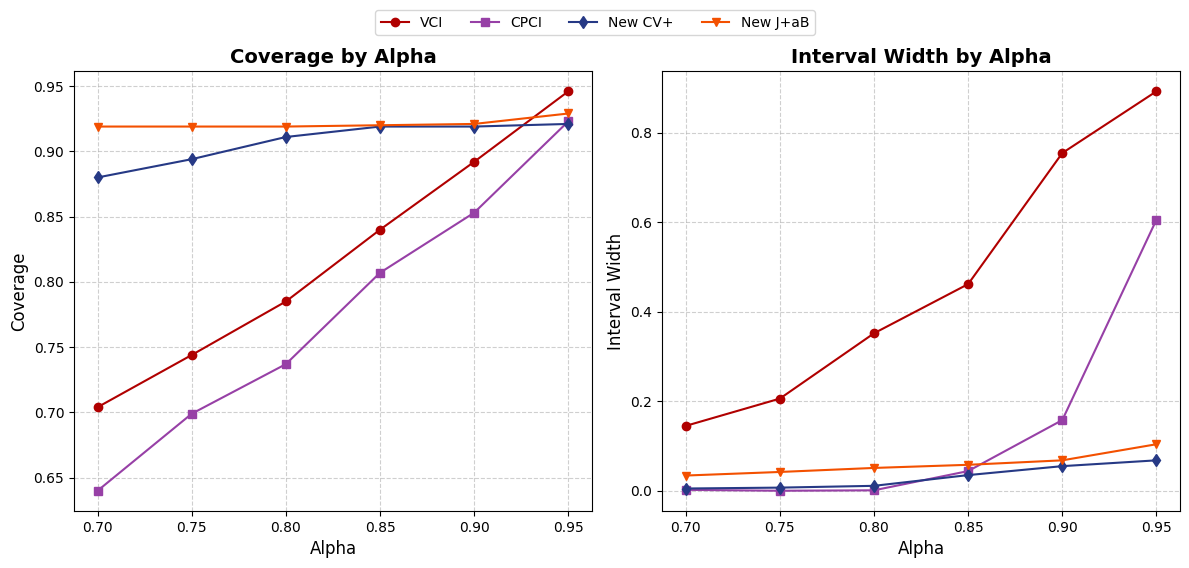

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Coverage line plot
for label, metrics, color, marker in zip(
    ['VCI', 'CPCI', 'New CV+', 'New J+aB'],# 'Old CV+', 'Old J+aB', ],
    [conformal_metrics_vanilla, conformal_metrics_last_v1_beta_tilde,
     conformal_metrics_new_cv, conformal_metrics_new_jackknife_plus_ab],
    #  conformal_metrics_old_cv, conformal_metrics_old_jackknife_plus_ab],
    ['#B00000', '#9740A6', '#263985', '#F35000', '#0097B2', '#eb8f63'],
    ['o', 's', 'd', 'v', 'p', 'h']
):
    ax[0].plot(metrics["alpha"], metrics["coverage"], marker=marker, label=label, color=color)
# ax[0].plot([0.85, 0.95], [0.85, 0.95], linestyle='--', color='black', label='Desired Coverage')
ax[0].set_xlabel('Alpha', fontsize=12)
ax[0].set_ylabel('Coverage', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].set_title('Coverage by Alpha', fontsize=14, weight="bold")

# Interval Width line plot
for label, metrics, color, marker in zip(
    ['VCI', 'CPCI', 'New CV+', 'New J+aB'],# 'Old CV+', 'Old J+aB', ],
    [conformal_metrics_vanilla, conformal_metrics_last_v1_beta_tilde,
     conformal_metrics_new_cv, conformal_metrics_new_jackknife_plus_ab],
    #  conformal_metrics_old_cv, conformal_metrics_old_jackknife_plus_ab],
    ['#B00000', '#9740A6', '#263985', '#F35000', '#0097B2', '#eb8f63'],
    ['o', 's', 'd', 'v', 'p', 'h']

):
    ax[1].plot(metrics["alpha"], metrics["interval_width"], marker=marker, label=label, color=color)

ax[1].set_xlabel('Alpha', fontsize=12)
ax[1].set_ylabel('Interval Width', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].set_title('Interval Width by Alpha', fontsize=14, weight="bold")

# Adjust layout
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=6, fontsize=10, bbox_to_anchor=(0.5, 0.95), frameon=True)
plt.tight_layout(rect=[0, 0, 1, 0.9]) 
# fig.suptitle('Comparison of Conformal Methods', fontsize=14, weight='bold')
plt.savefig('conformal_methods_comparison.svg', transparent=True, bbox_inches='tight')
plt.show()

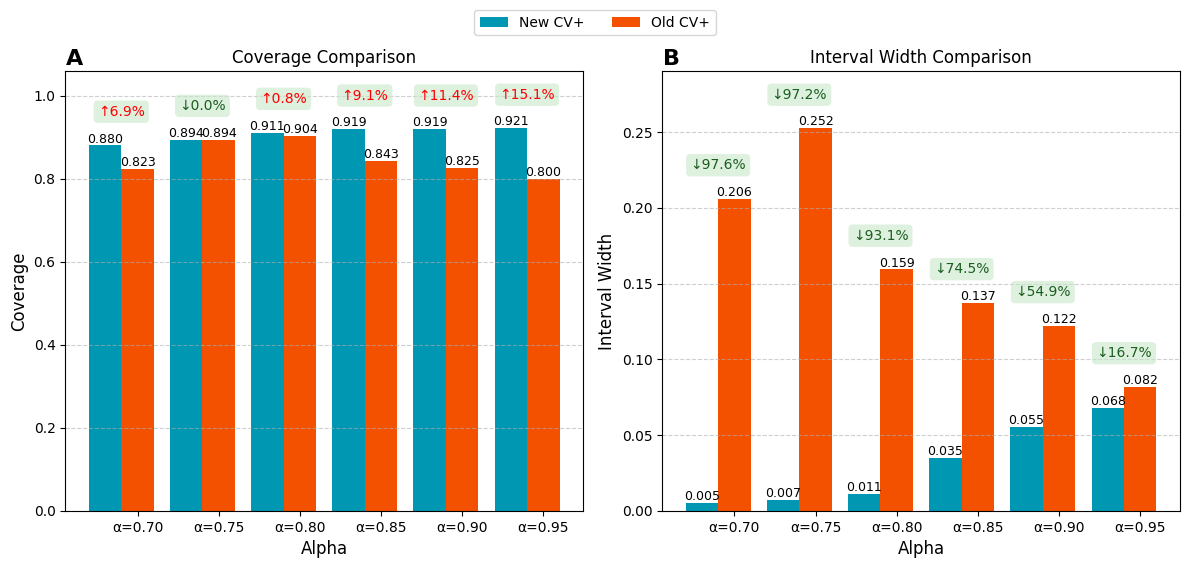

In [11]:
width = 0.4  # Adjusted bar width
x = np.arange(len(conformal_metrics_new_cv["alpha"]))

# Compute differences
diff_coverage = (np.array(conformal_metrics_old_cv["coverage"]) - np.array(conformal_metrics_new_cv["coverage"])) / np.array(conformal_metrics_old_cv["coverage"]) * 100
diff_interval = (np.array(conformal_metrics_old_cv["interval_width"]) - np.array(conformal_metrics_new_cv["interval_width"])) / np.array(conformal_metrics_old_cv["interval_width"]) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# fig.suptitle('CV+ Comparison', fontsize=16, weight='bold')

# Coverage Comparison
bar1 = ax1.bar(x - width, conformal_metrics_new_cv["coverage"], width, label='New CV+', color='#0097B2')
bar2 = ax1.bar(x, conformal_metrics_old_cv["coverage"], width, label='Old CV+', color='#F35000')

def add_value_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

add_value_labels(bar1, ax1)
add_value_labels(bar2, ax1)

# Set y-axis limits with padding for annotations
max_coverage = max(max(conformal_metrics_new_cv["coverage"]), max(conformal_metrics_old_cv["coverage"]))
ax1.set_ylim(0, max_coverage * 1.15)  # Add 15% padding

ax1.set_xticks(x)
ax1.set_xticklabels([f'α={alpha:.2f}' for alpha in conformal_metrics_new_cv["alpha"]])
ax1.set_xlabel('Alpha', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.set_title('Coverage Comparison', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Interval Width Comparison
bar3 = ax2.bar(x - width, conformal_metrics_new_cv["interval_width"], width, color='#0097B2')
bar4 = ax2.bar(x, conformal_metrics_old_cv["interval_width"], width, color='#F35000')

add_value_labels(bar3, ax2)
add_value_labels(bar4, ax2)

# Set y-axis limits with padding for annotations
max_interval = max(max(conformal_metrics_new_cv["interval_width"]), max(conformal_metrics_old_cv["interval_width"]))
ax2.set_ylim(0, max_interval * 1.15)  # Add 15% padding

ax2.set_xticks(x)
ax2.set_xticklabels([f'α={alpha:.2f}' for alpha in conformal_metrics_new_cv["alpha"]])

ax2.set_xlabel('Alpha', fontsize=12)
ax2.set_ylabel('Interval Width', fontsize=12)
ax2.set_title('Interval Width Comparison', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.6)

# Define annotation properties
bbox_props = dict(boxstyle="round,pad=0.3", fc='#C8E6C9', ec="none", alpha=0.6)

for i, (diff_cov, diff_int) in enumerate(zip(diff_coverage, diff_interval)):
    # Coverage reduction
    max_cov = max(conformal_metrics_new_cv["coverage"][i], conformal_metrics_old_cv["coverage"][i])
    annotation_height_cov = max_cov + (max_coverage * 0.07)  # Position at 3% above the bar
    
    if diff_cov > 0:
        ax1.text(x[i] - width/2, annotation_height_cov,
                f'↓{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='#1B5E20', bbox=bbox_props)
    else:
        ax1.text(x[i] - width/2, annotation_height_cov,
                f'↑{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='red', bbox=bbox_props)

    # Interval width reduction
    max_int = max(conformal_metrics_new_cv["interval_width"][i], conformal_metrics_old_cv["interval_width"][i])
    annotation_height_int = max_int + (max_interval * 0.07)  # Position at 3% above the bar
    
    if diff_int > 0:
        ax2.text(x[i] - width/2, annotation_height_int,
                f'↓{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='#1B5E20', bbox=bbox_props)
    else:
        ax2.text(x[i] - width/2, annotation_height_int,
                f'↑{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='red', bbox=bbox_props)
        
# Add letters A and B to the subplots
ax1.text(0.035, 1.05, 'A', transform=ax1.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(0.035, 1.05, 'B', transform=ax2.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10, 
          bbox_to_anchor=(0.5, 0.95), frameon=True)

# Adjust layout and show
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig('cv+_comparison.svg', transparent=True, bbox_inches='tight')
plt.show()

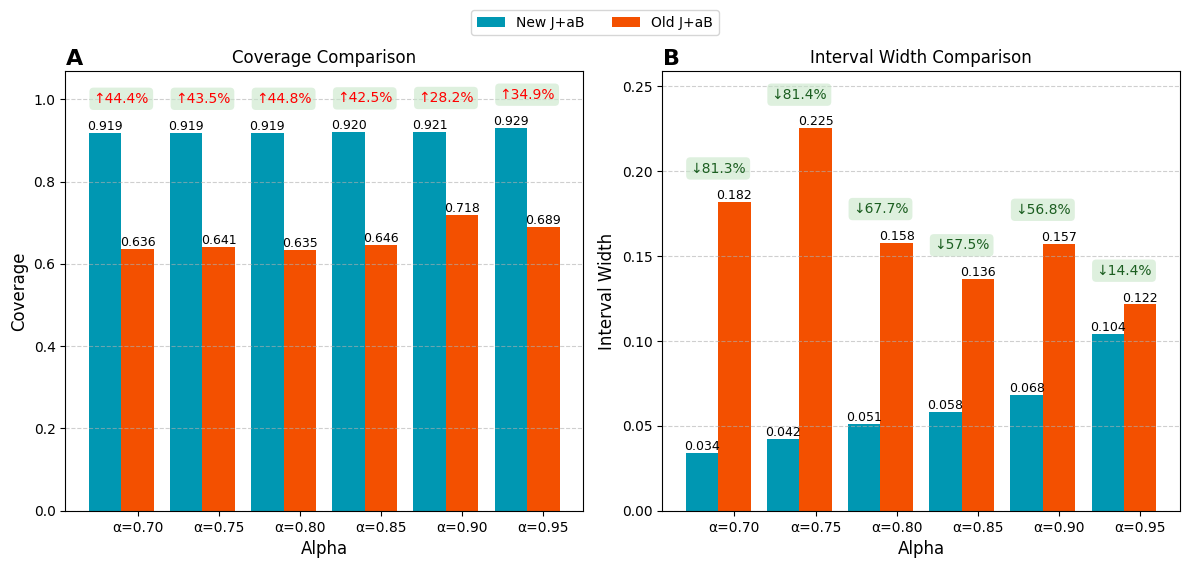

In [12]:
width = 0.4  # Adjusted bar width
x = np.arange(len(conformal_metrics_new_jackknife_plus_ab["alpha"]))

# Compute differences
diff_coverage = (np.array(conformal_metrics_old_jackknife_plus_ab["coverage"]) - np.array(conformal_metrics_new_jackknife_plus_ab["coverage"])) / np.array(conformal_metrics_old_jackknife_plus_ab["coverage"]) * 100
diff_interval = (np.array(conformal_metrics_old_jackknife_plus_ab["interval_width"]) - np.array(conformal_metrics_new_jackknife_plus_ab["interval_width"])) / np.array(conformal_metrics_old_jackknife_plus_ab["interval_width"]) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# fig.suptitle('J+aB Comparison', fontsize=16, weight='bold')

# Coverage Comparison
bar1 = ax1.bar(x - width, conformal_metrics_new_jackknife_plus_ab["coverage"], width, label='New J+aB', color='#0097B2')
bar2 = ax1.bar(x, conformal_metrics_old_jackknife_plus_ab["coverage"], width, label='Old J+aB', color='#F35000')

def add_value_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

add_value_labels(bar1, ax1)
add_value_labels(bar2, ax1)

# Set y-axis limits with padding for annotations
max_coverage = max(max(conformal_metrics_new_jackknife_plus_ab["coverage"]), max(conformal_metrics_old_jackknife_plus_ab["coverage"]))
ax1.set_ylim(0, max_coverage * 1.15)  # Add 15% padding

ax1.set_xticks(x)
ax1.set_xticklabels([f'α={alpha:.2f}' for alpha in conformal_metrics_new_jackknife_plus_ab["alpha"]])
ax1.set_xlabel('Alpha', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.set_title('Coverage Comparison', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Interval Width Comparison
bar3 = ax2.bar(x - width, conformal_metrics_new_jackknife_plus_ab["interval_width"], width, color='#0097B2')
bar4 = ax2.bar(x, conformal_metrics_old_jackknife_plus_ab["interval_width"], width, color='#F35000')

add_value_labels(bar3, ax2)
add_value_labels(bar4, ax2)

# Set y-axis limits with padding for annotations
max_interval = max(max(conformal_metrics_new_jackknife_plus_ab["interval_width"]), max(conformal_metrics_old_jackknife_plus_ab["interval_width"]))
ax2.set_ylim(0, max_interval * 1.15)  # Add 15% padding

ax2.set_xticks(x)
ax2.set_xticklabels([f'α={alpha:.2f}' for alpha in conformal_metrics_new_jackknife_plus_ab["alpha"]])

ax2.set_xlabel('Alpha', fontsize=12)
ax2.set_ylabel('Interval Width', fontsize=12)
ax2.set_title('Interval Width Comparison', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.6)

# Define annotation properties
bbox_props = dict(boxstyle="round,pad=0.3", fc='#C8E6C9', ec="none", alpha=0.6)

for i, (diff_cov, diff_int) in enumerate(zip(diff_coverage, diff_interval)):
    # Coverage reduction
    max_cov = max(conformal_metrics_new_jackknife_plus_ab["coverage"][i], conformal_metrics_old_jackknife_plus_ab["coverage"][i])
    annotation_height_cov = max_cov + (max_coverage * 0.07)  # Position at 3% above the bar
    
    if diff_cov > 0:
        ax1.text(x[i] - width/2, annotation_height_cov,
                f'↓{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='#1B5E20', bbox=bbox_props)
    else:
        ax1.text(x[i] - width/2, annotation_height_cov,
                f'↑{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='red', bbox=bbox_props)

    # Interval width reduction
    max_int = max(conformal_metrics_new_jackknife_plus_ab["interval_width"][i], conformal_metrics_old_jackknife_plus_ab["interval_width"][i])
    annotation_height_int = max_int + (max_interval * 0.07)  # Position at 3% above the bar
    
    if diff_int > 0:
        ax2.text(x[i] - width/2, annotation_height_int,
                f'↓{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='#1B5E20', bbox=bbox_props)
    else:
        ax2.text(x[i] - width/2, annotation_height_int,
                f'↑{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='red', bbox=bbox_props)
        
# Add letters A and B to the subplots
ax1.text(0.035, 1.05, 'A', transform=ax1.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(0.035, 1.05, 'B', transform=ax2.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10, 
          bbox_to_anchor=(0.5, 0.95), frameon=True)

# Adjust layout and show
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig('j+ab_comparison.svg', transparent=True, bbox_inches='tight')
plt.show()